# Khmer to English

In [1]:
import os

EMBED_DIM = 32
LSTM_UNITS = 64
BATCH_SIZE = 16
EPOCHS = 50
BEAM_WIDTH = 3

BASE_DIR = os.path.dirname(os.path.abspath('.'))
DATA_PATH = os.path.join(BASE_DIR, "data", "raw", "eng_khm_data.csv")
MODEL_PATH = os.path.join(BASE_DIR, "models", "english_romanizer.keras")
ASSETS_PATH = os.path.join(BASE_DIR, "data", "processed", "english_romanization_assets.pkl")

## Preprocessing

In [2]:
import pandas as pd
import unicodedata
import re

# load dataset and process into pairs (reversed for khmer to english)
df = pd.read_csv(DATA_PATH)
dataset = []

for _, row in df.iterrows():
    normalized_khm = re.sub(r"[^\u1780-\u17FF]", "", row['khm'])
    normalized_khm = unicodedata.normalize('NFC', normalized_khm)
    
    normalized_eng = re.sub(r"[^a-z]", "", row['eng'].lower())

    dataset.append((normalized_khm, normalized_eng))

In [3]:
# first 5 pairs
dataset[:5]

[('ប្រដែ', 'brodae'),
 ('អសង្ខៃយ', 'aasangkheyy'),
 ('ឆាតកភ័យ', 'chhatkophey'),
 ('ទព្វសម្ភារៈ', 'topvosompheareak'),
 ('ទោចក្រយាន', 'touchkroyean')]

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenize khmer and english texts
khm_tokenizer = Tokenizer(char_level=True, filters='', oov_token='<unk>')
khm_tokenizer.fit_on_texts([pair[0] for pair in dataset])

eng_tokenizer = Tokenizer(char_level=True, filters='', oov_token='<unk>')
eng_tokenizer.fit_on_texts(["\t", "\n"] + [pair[1] for pair in dataset])

2025-12-10 16:34:50.938708: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-10 16:34:50.942867: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-10 16:34:51.416186: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-10 16:34:53.088247: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [5]:
print("Khmer tokenizer vocab size:", len(khm_tokenizer.word_index) + 1)
print("Khmer tokenizer word index:", khm_tokenizer.word_index)

print("\nEnglish tokenizer vocab size:", len(eng_tokenizer.word_index) + 1)
print("English tokenizer word index:", eng_tokenizer.word_index)

Khmer tokenizer vocab size: 79
Khmer tokenizer word index: {'<unk>': 1, '្': 2, 'ា': 3, 'រ': 4, 'ក': 5, 'ស': 6, 'ប': 7, 'ត': 8, 'ន': 9, 'ម': 10, 'ង': 11, 'ិ': 12, 'ល': 13, 'អ': 14, 'ច': 15, 'ុ': 16, 'វ': 17, 'ទ': 18, 'យ': 19, '់': 20, 'ព': 21, 'ំ': 22, 'ហ': 23, 'ោ': 24, 'ជ': 25, 'េ': 26, 'គ': 27, 'ី': 28, 'ណ': 29, 'ញ': 30, 'ដ': 31, 'ូ': 32, 'ភ': 33, 'ែ': 34, 'ធ': 35, 'ខ': 36, 'ើ': 37, '៉': 38, 'ះ': 39, 'ឹ': 40, 'ួ': 41, 'ឡ': 42, 'ថ': 43, 'ផ': 44, 'ៀ': 45, '័': 46, 'ៈ': 47, 'ឆ': 48, '៍': 49, 'ៃ': 50, '៊': 51, 'ឋ': 52, 'ឺ': 53, 'ៗ': 54, 'ឌ': 55, 'ឧ': 56, 'ៅ': 57, 'ឃ': 58, 'ឈ': 59, '៌': 60, 'ឿ': 61, 'ឥ': 62, 'ឱ': 63, 'ឫ': 64, 'ឯ': 65, 'ឍ': 66, '៎': 67, '៏': 68, 'ឪ': 69, 'ឩ': 70, 'ឲ': 71, 'ឦ': 72, 'ឮ': 73, 'ឰ': 74, 'ឳ': 75, '។': 76, 'ឭ': 77, 'ឬ': 78}

English tokenizer vocab size: 30
English tokenizer word index: {'<unk>': 1, 'a': 2, 'o': 3, 'h': 4, 'e': 5, 'n': 6, 'r': 7, 'k': 8, 't': 9, 'u': 10, 's': 11, 'm': 12, 'b': 13, 'i': 14, 'c': 15, 'p': 16, 'l': 17, 'g': 18, 'y': 19, 'v': 20, 'd'

In [6]:
# create sequences
encoder_inputs, decoder_inputs, decoder_targets = [], [], []
max_khm_len = max(len(pair[0]) for pair in dataset) or 1
max_eng_len = max(len(pair[1]) for pair in dataset) or 1

for khm, eng in dataset:
    # encoder sequence (khmer)
    khm_seq = khm_tokenizer.texts_to_sequences([khm])[0]
    encoder_inputs.append(khm_seq)

    # decoder sequences (english)
    eng_seq = eng_tokenizer.texts_to_sequences([eng])[0]
    decoder_input = [eng_tokenizer.word_index['\t']] + eng_seq
    decoder_target = eng_seq + [eng_tokenizer.word_index['\n']]
    
    decoder_inputs.append(decoder_input)
    decoder_targets.append(decoder_target)

encoder_data = pad_sequences(encoder_inputs, maxlen=max_khm_len, padding='post')
decoder_input_data = pad_sequences(decoder_inputs, maxlen=max_eng_len + 1, padding='post')
decoder_target_data = pad_sequences(decoder_targets, maxlen=max_eng_len + 1, padding='post')

## Model

seq2seq for khmer to english text romanization

In [7]:
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.models import Model

import numpy as np

In [8]:
# encoder (khmer input)
encoder_inputs = Input(shape=(None,), name='encoder_inputs')
encoder_embedding = Embedding(
    input_dim=len(khm_tokenizer.word_index) + 1, 
    output_dim=EMBED_DIM, 
    name='encoder_embedding'
)(encoder_inputs)
encoder_lstm = LSTM(LSTM_UNITS, return_state=True, name='encoder_lstm')
_, state_h, state_c = encoder_lstm(encoder_embedding)

# decoder (english output)
decoder_inputs = Input(shape=(None,), name='decoder_inputs')
decoder_embedding = Embedding(
    input_dim=len(eng_tokenizer.word_index) + 1, 
    output_dim=EMBED_DIM, 
    name='decoder_embedding'
)(decoder_inputs)
decoder_lstm = LSTM(LSTM_UNITS, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])
decoder_dense = Dense(len(eng_tokenizer.word_index) + 1, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# build model
model = Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name='seq2seq_model'
)

# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

E0000 00:00:1765359314.817586  178492 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765359314.943697  178492 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
# train model
khm_to_eng_train = model.fit(
    [encoder_data, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
)

Epoch 1/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7500 - loss: 0.8422 - val_accuracy: 0.7755 - val_loss: 0.7122
Epoch 2/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7853 - loss: 0.6711 - val_accuracy: 0.8007 - val_loss: 0.6215
Epoch 3/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8159 - loss: 0.5706 - val_accuracy: 0.8282 - val_loss: 0.5348
Epoch 4/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8380 - loss: 0.4999 - val_accuracy: 0.8447 - val_loss: 0.4759
Epoch 5/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8556 - loss: 0.4433 - val_accuracy: 0.8630 - val_loss: 0.4240
Epoch 6/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8690 - loss: 0.3990 - val_accuracy: 0.8747 - val_loss: 0.3851
Epoch 7/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8797 - loss: 0.3647 - val_accuracy: 0.8837 - val_loss: 0.3584
Epoch 8/50
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8893 - loss: 

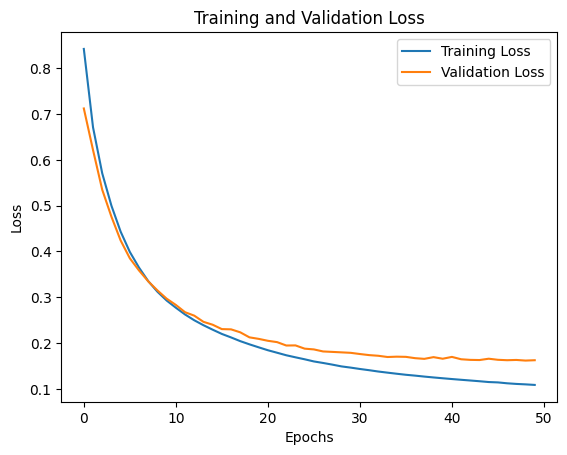

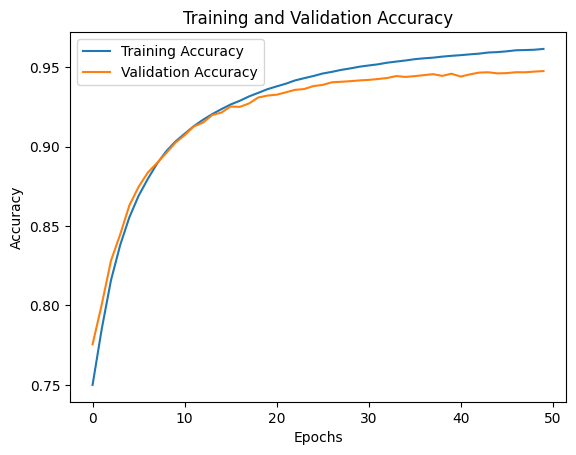

In [10]:
import matplotlib.pyplot as plt

# plot training loss
plt.plot(khm_to_eng_train.history['loss'], label='Training Loss')
plt.plot(khm_to_eng_train.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(khm_to_eng_train.history['accuracy'], label='Training Accuracy')
plt.plot(khm_to_eng_train.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
import pickle

# save model
model.save(MODEL_PATH)
assets = {
    "khm_tokenizer": khm_tokenizer,
    "eng_tokenizer": eng_tokenizer,
    "max_khm_len": max_khm_len,
    "max_eng_len": max_eng_len
}

with open(ASSETS_PATH, "wb") as file:
    pickle.dump(assets, file)
file.close()

## Predict

In [12]:
import numpy as np

# load assets
with open(ASSETS_PATH, "rb") as file:
    assets = pickle.load(file)
file.close()

khm_tokenizer = assets["khm_tokenizer"]
eng_tokenizer = assets["eng_tokenizer"]
max_khm_len = assets["max_khm_len"]
max_eng_len = assets["max_eng_len"]

In [13]:
from tensorflow.keras.models import Model, load_model

# load model
model = load_model(MODEL_PATH)

encoder_inputs = model.input[0]
encoder_outputs, state_h, state_c = model.get_layer("encoder_lstm").output
encoder_model = Model(encoder_inputs, [state_h, state_c])

In [14]:
# decoder setup
decoder_inputs = model.input[1]
decoder_state_input_h = Input(shape=(LSTM_UNITS,))
decoder_state_input_c = Input(shape=(LSTM_UNITS,))
decoder_states = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = model.get_layer("decoder_lstm")(
    model.get_layer("decoder_embedding")(decoder_inputs),
    initial_state=decoder_states
)
decoder_outputs = model.get_layer("decoder_dense")(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states,
    [decoder_outputs, state_h, state_c]
)

In [15]:
# romanization function
def romanize(text):
    # clean input (khmer)
    text = str(text).strip()
    text = re.sub(r"[^\u1780-\u17FF]", "", text)
    text = unicodedata.normalize('NFC', text)

    if not text:
        return ""

    # encode input
    seq = khm_tokenizer.texts_to_sequences([text])
    encoder_input = pad_sequences(seq, maxlen=max_khm_len, padding='post')
    states = encoder_model.predict(encoder_input)

    # decode output
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = eng_tokenizer.word_index['\t']
    stop_condition = False
    decoded_chars = []

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states)
        char_index = np.argmax(output_tokens[0, -1, :])
        char = eng_tokenizer.index_word.get(char_index, '')

        if char == '\n' or len(decoded_chars) >= max_eng_len + 1:
            stop_condition = True
        else:
            decoded_chars.append(char)
            target_seq[0, 0] = char_index
            states = [h, c]
    
    return ''.join(decoded_chars)

In [16]:
# test with some khmer text
romanize("ហេឡូ")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


'helh'

In [17]:
romanize("ត្រាប")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


'trab'

In [18]:
romanize("មានលុយ")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


'meanoley'

In [19]:
romanize("ខ្ដាស់")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


'khdas'